In [1]:
%matplotlib inline

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import FormatStrFormatter

In [3]:
def save_plot(fig, pltname, artists=(), size_inches=(4,4)):
    fig.set_size_inches(size_inches)
    fig.savefig(os.path.join("..", "figures", "permutation_tests_" + pltname + ".png"), dpi=300, bbox_extra_artists=artists, bbox_inches='tight')

In [4]:
# Load up the mapping file
df_mapping = pd.read_csv("../data/SampleID_map.txt", sep='\t', index_col=0)
df_mapping.head()

,UserName,StudyDayNo,StudyDate,Gender,Age,Weight,Height,BMI,Supplement,Waist.Circumference,...,fecal.time,BMI.1,Weight.Change,Plate,SampleOrder,SampleType,Timing,Activity.Factor,Medications,Dietary.Supp
#SampleID,,,,,,,,,,,,,,,,,,,,,
Blank.A02.,Blank_A02,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A03.,Blank_A03,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A04.,Blank_A04,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A07.,Blank_A07,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.B12.,Blank_B12,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,Blank,NaN,NaN,NaN,NaN


In [35]:
# Load up the distance matrix
df_distance = pd.read_csv("../data/AllRf.dm.txt", sep='\t', index_col=0)
# Reflect lower triangle to upper triangle
for i in range(df_distance.shape[0]):
    for j in range(i, df_distance.shape[1]):
        df_distance.iloc[i, j] = df_distance.iloc[j, i]
        if i == j:
            df_distance.iloc[i, j] = 0.
df_distance.head()

,MCT.f.0072,MCT.f.0014,MCT.f.0269,MCT.f.0259,MCT.f.0221,MCT.f.0426,MCT.f.0590,MCT.f.0624,MCT.f.0138,MCT.f.0166,...,MCT.f.0404,MCT.f.0439,MCT.f.0365,MCT.f.0220,MCT.f.0048,MCT.f.0456,MCT.f.0550,MCT.f.0524,MCT.f.0489,MCT.f.0621
MCT.f.0072,0.0000,2.5560,2.5009,2.4233,2.4425,2.2992,3.0320,2.0747,2.3113,2.5819,...,3.0163,2.4577,2.5237,2.5709,2.3318,2.3771,2.3528,2.8761,3.2440,2.1268
MCT.f.0014,2.5560,0.0000,2.3440,2.5015,2.4130,2.4851,2.6786,2.7548,2.4207,2.3409,...,2.9536,2.4503,2.3645,2.5488,2.4964,2.3574,2.3724,2.8883,2.8061,2.7111
MCT.f.0269,2.5009,2.3440,0.0000,2.2691,2.4331,2.4931,2.8162,2.6454,2.4783,2.5384,...,3.0341,2.5369,2.4298,2.5900,2.5071,2.4186,2.4096,2.9128,2.8895,2.6058
MCT.f.0259,2.4233,2.5015,2.2691,0.0000,2.4704,2.4973,2.9089,2.5159,2.4960,2.6310,...,3.0832,2.5564,2.5028,2.6198,2.5343,2.4570,2.4483,2.9434,2.9876,2.5266
MCT.f.0221,2.4425,2.4130,2.4331,2.4704,0.0000,2.3441,2.7912,2.3562,2.4271,2.4306,...,3.0070,2.3995,2.4515,2.1220,2.4451,2.4111,2.2562,2.8241,2.9270,2.3435


In [6]:
# summary statistic
def difference_of_stats(samples, df_distance):
    s = 0.
    for i in range(len(samples)-1):
        s += df_distance[samples[i]][samples[i+1]]
    return s

In [8]:
NUM_PERMUTATIONS = 100000
statistics_original = dict()
statistics_permuted = dict()

# Retrieve a vector sample numbers, in order of date
for group, df in df_mapping.groupby('UserName'):
    if 'Blank' not in group:
        df = df.sort_values('StudyDayNo')
        # Remove samples not in akronymer
        df = df[[_ in df_distance.index for _ in df.index]]
        # Verify after filter there are more than 1 sample
        if df.shape[0] > 1:
            diff = np.diff(df['StudyDayNo']) == 1
            # Double the first value for indexing
            diff = np.insert(diff, 0, diff[0], axis=0)
            df = df[diff]
            # Verify after filter there are more than 1 sample
            if df.shape[0] > 1:
                statistics_permuted[group] = np.zeros(NUM_PERMUTATIONS)
                statistics_original[group] = difference_of_stats(df.index, df_distance)
                for i in range(NUM_PERMUTATIONS):
                    x = np.array(df.index)
                    np.random.shuffle(x)
                    statistics_permuted[group][i] = difference_of_stats(x, df_distance)

In [9]:
# Flatten the dictionaries
flattened_statistics_original = np.zeros(len(statistics_permuted.keys()))
for i, (key, value) in enumerate(statistics_original.items()):
    flattened_statistics_original[i] = value

# Flatten the 
flattened_statistics_permuted = np.zeros((len(statistics_permuted.keys()), NUM_PERMUTATIONS))
for i, (key, value) in enumerate(statistics_permuted.items()):
    flattened_statistics_permuted[i, :] = value

In [10]:
# Check for significance of order
print((np.sum(flattened_statistics_original.sum() >= flattened_statistics_permuted.sum(axis=0))/(NUM_PERMUTATIONS+1)))

9.999900001e-06


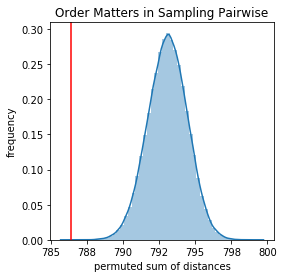

In [13]:
fig, ax = plt.subplots()
sns.distplot(flattened_statistics_permuted.sum(axis=0), ax=ax)
plt.axvline(x=flattened_statistics_original.sum(), color='red')
ax.set_ylabel('frequency')
ax.set_xlabel('permuted sum of distances')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_title('Order Matters in Sampling Pairwise')
#ax.set_xlim(flattened_statistics_original.sum()-1, flattened_statistics_permuted.sum(axis=0).max()+1)
save_plot(fig, 'ordermatters_hist')

In [34]:
# Load up the distance matrix
df_distance_tree = pd.read_csv("../data/buttiques.dm.txt", sep=' ', index_col=None)
# Reflect lower triangle to upper triangle
#for i in range(df_distance.shape[0]):
#    for j in range(i, df_distance.shape[1]):
#        df_distance.iloc[i, j] = df_distance.iloc[j, i]
# Why are some values greater than 100?
#print(np.sum(df_distance.values <= 100, axis=1))

#df_distance.values[df_distance.values >= 100] = df_distance.values[df_distance.values >= 100] - 100
df_distance_tree.index = df_distance_tree.columns
df_distance_tree.head()

,MCT.f.0187,MCT.f.0186,MCT.f.0185,MCT.f.0183,MCT.f.0176,MCT.f.0173,MCT.f.0180,MCT.f.0174,MCT.f.0171,MCT.f.0172,...,MCT.f.0593,MCT.f.0579,MCT.f.0585,MCT.f.0586,MCT.f.0587,MCT.f.0581,MCT.f.0580,MCT.f.0582,MCT.f.0592,MCT.f.0590
MCT.f.0187,0.00000,2.44516,2.43706,2.40814,2.47953,2.46072,2.57432,2.58551,2.39018,2.35707,...,2.98129,2.98894,2.98254,3.04049,3.07848,3.07606,3.07938,3.21168,3.08105,2.96410
MCT.f.0186,2.44516,0.00000,2.25576,2.24940,2.35537,2.33656,2.45016,2.46135,2.26602,2.23291,...,2.85713,2.86478,2.85838,2.91633,2.95432,2.95190,2.95522,3.08752,2.95689,2.83994
MCT.f.0185,2.43706,2.25576,0.00000,2.24130,2.34727,2.32846,2.44206,2.45325,2.25792,2.22481,...,2.84903,2.85668,2.85028,2.90823,2.94622,2.94380,2.94712,3.07942,2.94879,2.83184
MCT.f.0183,2.40814,2.24940,2.24130,0.00000,2.31835,2.29954,2.41314,2.42433,2.22900,2.19589,...,2.82011,2.82776,2.82136,2.87931,2.91730,2.91488,2.91820,3.05050,2.91987,2.80292
MCT.f.0176,2.47953,2.35537,2.34727,2.31835,0.00000,2.28581,2.39941,2.41060,2.21527,2.18216,...,2.84612,2.85377,2.84737,2.90532,2.94331,2.94089,2.94421,3.07651,2.94588,2.82893


In [40]:
df_corr = df_distance.corrwith(df_distance_tree)

fig, ax = plt.subplots()
sns.heatmap(np.abs(df_distance/df_distance.max()-(df_distance_tree/df_distance_tree.max()).loc[df_distance.index, df_distance.index]), ax=ax)
# plt.axvline(x=flattened_statistics_original.sum(), color='red')
# ax.set_ylabel('frequency')
# ax.set_xlabel('permuted sum of distances')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# ax.set_title('Order Matters in Sampling Pairwise')
#ax.set_xlim(flattened_statistics_original.sum()-1, flattened_statistics_permuted.sum(axis=0).max()+1)
save_plot(fig, 'heatmap_tree_pairwise', size_inches=(8,8))

AttributeError: 'numpy.ndarray' object has no attribute '_get_numeric_data'

In [36]:
np.abs((df_distance)-df_distance_tree.loc[df_distance.index, df_distance.index])

,MCT.f.0072,MCT.f.0014,MCT.f.0269,MCT.f.0259,MCT.f.0221,MCT.f.0426,MCT.f.0590,MCT.f.0624,MCT.f.0138,MCT.f.0166,...,MCT.f.0404,MCT.f.0439,MCT.f.0365,MCT.f.0220,MCT.f.0048,MCT.f.0456,MCT.f.0550,MCT.f.0524,MCT.f.0489,MCT.f.0621
MCT.f.0072,0.00000,0.19543,0.00608,0.14274,0.02184,0.19775,0.15360,0.54129,0.17200,0.05379,...,0.00340,0.08256,0.02364,0.04066,0.21349,0.06283,0.06225,0.02680,0.25902,0.50057
MCT.f.0014,0.19543,0.00000,0.03253,0.05375,0.06695,0.10644,0.08151,0.25710,0.05569,0.06892,...,0.05219,0.02833,0.01727,0.05553,0.06940,0.03576,0.07564,0.10369,0.06059,0.20202
MCT.f.0269,0.00608,0.03253,0.00000,0.00800,0.03120,0.02285,0.00024,0.05611,0.00070,0.07273,...,0.07684,0.02334,0.00004,0.04088,0.00643,0.01563,0.02125,0.07234,0.03560,0.00513
MCT.f.0259,0.14274,0.05375,0.00800,0.00000,0.00272,0.04417,0.02172,0.14461,0.05282,0.09411,...,0.05472,0.02838,0.00174,0.00054,0.05045,0.04845,0.01127,0.03172,0.00872,0.14529
MCT.f.0221,0.02184,0.06695,0.03120,0.00272,0.00000,0.09567,0.02466,0.20261,0.02002,0.01435,...,0.09916,0.08358,0.04436,0.04070,0.03795,0.00735,0.10167,0.03306,0.03238,0.22669
MCT.f.0426,0.19775,0.10644,0.02285,0.04417,0.09567,0.00000,0.07537,0.27018,0.08023,0.01796,...,0.00303,0.02597,0.01459,0.09799,0.07212,0.03386,0.04684,0.02173,0.12299,0.30656
MCT.f.0590,0.15360,0.08151,0.00024,0.02172,0.02466,0.07537,0.00000,0.12473,0.05722,0.05573,...,0.63962,0.04684,0.02110,0.03834,0.02729,0.05489,0.08777,0.33952,0.23538,0.12095
MCT.f.0624,0.54129,0.25710,0.05611,0.14461,0.20261,0.27018,0.12473,0.00000,0.16537,0.08072,...,0.01397,0.19709,0.01637,0.15283,0.26786,0.04460,0.05638,0.13747,0.24975,0.02202
MCT.f.0138,0.17200,0.05569,0.00070,0.05282,0.02002,0.08023,0.05722,0.16537,0.00000,0.03251,...,0.01172,0.01424,0.01594,0.02274,0.07547,0.06191,0.01623,0.01458,0.10684,0.16305
MCT.f.0166,0.05379,0.06892,0.07273,0.09411,0.01435,0.01796,0.05573,0.08072,0.03251,0.00000,...,0.02633,0.03495,0.03379,0.00107,0.05238,0.02228,0.00074,0.10733,0.01361,0.09834


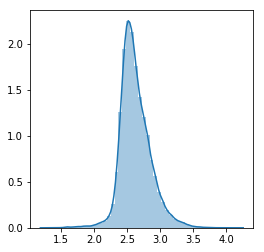

In [43]:
fig, ax = plt.subplots()
values = np.triu(df_distance_tree.values)
values = values[values > 0].flatten()
sns.distplot(values, ax=ax)
save_plot(fig, 'tree_distribution_distances')

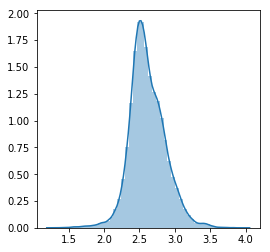

In [44]:
fig, ax = plt.subplots()
values = np.triu(df_distance.values)
values = values[values > 0].flatten()
sns.distplot(values, ax=ax)
save_plot(fig, 'pairwise_distribution_distances')

In [27]:
NUM_PERMUTATIONS = 10000
df_filter_blanks = df_mapping[['Blank' not in _ for _ in df_mapping['UserName']]]

df_filter_blanks = df_filter_blanks.reindex(df_distance.index)

groups_filter = set()
for group, df in df_filter_blanks.groupby('UserName'):
    # Remove samples not in akronymer
    df = df[[_ in df_distance.index for _ in df.index]]
    # Verify after filter there are more than 1 sample        
    if df.shape[0] <= 1:
        groups_filter.add(group)

df_filter_blanks = df_filter_blanks[[_ not in groups_filter for _ in df_filter_blanks['UserName']]]

statistic_original = 0.
for group, df in df_filter_blanks.groupby('UserName'):
    statistic_original += df_distance.loc[df.index, df.index].sum().sum()/2

statistics_permuted = np.zeros(NUM_PERMUTATIONS)
for i in range(NUM_PERMUTATIONS):
    df_filter_blanks['UserName'] = np.random.permutation(df_filter_blanks['UserName'])
    for group, df in df_filter_blanks.groupby('UserName'):
        statistics_permuted[i] += df_distance.loc[df.index, df.index].sum().sum()/2

In [30]:
# Check for significance of order
print((np.sum(statistic_original >= statistics_permuted)+1)/(NUM_PERMUTATIONS+1.))

9.99900009999e-05


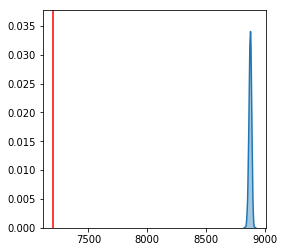

In [29]:
# Retrieve a vector sample numbers, in order of date
fig, ax = plt.subplots()
sns.distplot(statistics_permuted, ax=ax)
plt.axvline(x=statistic_original, color='red')
#ax.set_xlim(statistic_original-1, statistics_permuted.max()+1)
save_plot(fig, 'personmatters_hist')